## Model 1: Convolutional Neural Network (CNN) with Attention Layer

This section demonstrates how to build and train a Convolutional Neural Network (CNN) with an attention mechanism. The model is designed for image classification tasks. We will use the Keras library to construct the model, compile it, and train it on a dataset.

### Steps:
1. **Build the CNN model with an attention layer.**
2. **Compile the model with an appropriate optimizer and loss function.**
3. **Train the model on a given dataset.**
4. **Plot the training accuracy and loss.**
5. **Evaluate the model's performance.**
6. **Visualize the attention weights on sample images.**

In [43]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, Dataset
import matplotlib.pyplot as plt
import numpy as np
from typing import Tuple, Dict,List

In [94]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [6]:
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from typing import List, Tuple

# Define the transformation pipeline
transform: transforms.Compose = transforms.Compose([
    transforms.ToTensor(),  # Convert PIL Image to tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize with mean and std for each channel
])

# Load CIFAR-10 dataset
# trainset and testset are instances of torchvision.datasets.CIFAR10
trainset: torchvision.datasets.CIFAR10 = torchvision.datasets.CIFAR10(
    root='./data',  # Directory to store the dataset
    train=True,     # This is the training set
    download=True,  # Download if not present
    transform=transform  # Apply the defined transforms
)
testset: torchvision.datasets.CIFAR10 = torchvision.datasets.CIFAR10(
    root='./data', 
    train=False,    # This is the test set
    download=True, 
    transform=transform
)

# Set batch size for data loading
batch_size: int = 64

# Create data loaders
# DataLoader handles batching, shuffling, and parallel data loading
trainloader: DataLoader = DataLoader(
    trainset, 
    batch_size=batch_size, 
    shuffle=True,   # Shuffle the training data
    num_workers=2   # Number of subprocesses for data loading
)
testloader: DataLoader = DataLoader(
    testset, 
    batch_size=batch_size, 
    shuffle=False,  # No need to shuffle test data
    num_workers=2
)

# Class names for CIFAR-10 dataset (to simulate satellite image classes)
class_names: List[str] = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# If you need to access the raw data (similar to the original cell)
# Convert uint8 to float and normalize to [0, 1]
train_data: torch.Tensor = torch.tensor(trainset.data).float() / 255.0
test_data: torch.Tensor = torch.tensor(testset.data).float() / 255.0
train_labels: torch.Tensor = torch.tensor(trainset.targets)
test_labels: torch.Tensor = torch.tensor(testset.targets)

# Move data to GPU if available
device: torch.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_data = train_data.to(device)
test_data = test_data.to(device)
train_labels = train_labels.to(device)
test_labels = test_labels.to(device)

# Print shapes for verification
print(f"Train data shape: {train_data.shape}")
print(f"Test data shape: {test_data.shape}")
print(f"Train labels shape: {train_labels.shape}")
print(f"Test labels shape: {test_labels.shape}")

Files already downloaded and verified
Files already downloaded and verified
Train data shape: torch.Size([50000, 32, 32, 3])
Test data shape: torch.Size([10000, 32, 32, 3])
Train labels shape: torch.Size([50000])
Test labels shape: torch.Size([10000])


In [8]:
# Get a batch of test images and labels
test_images, test_labels = next(iter(testloader))

In [16]:
class CNNModel(nn.Module):
    """
    A Convolutional Neural Network (CNN) model implemented in PyTorch.
    """
    def __init__(self):
        super(CNNModel, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        
        # Pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Fully connected layers
        self.fc1 = nn.Linear(64 * 8 * 8, 64)  # Changed from 64 * 4 * 4 to 64 * 8 * 8
        self.fc2 = nn.Linear(64, 10)
        
        # Activation functions
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass of the model.

        Args:
        x (torch.Tensor): Input tensor of shape (batch_size, 3, 32, 32)

        Returns:
        torch.Tensor: Output tensor of shape (batch_size, 10)
        """

        #x = x.permute(0, 3, 1, 2)
        # Apply convolutional layers with ReLU activation and max pooling
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.relu(self.conv3(x))

        # print("Shape before reshape:", x.shape)  # Add this line
        
        # Flatten the output for the fully connected layers
        x = x.reshape(x.size(0), -1)
        
        # Apply fully connected layers with ReLU activation
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        
        # Apply softmax to the output
        x = self.softmax(x)
        
        return x

def create_cnn_model() -> nn.Module:
    """
    Creates a Convolutional Neural Network (CNN) model.

    Returns:
    nn.Module: The constructed CNN model.
    """
    return CNNModel()

In [24]:

# Create the model instance
cnn_model = CNNModel().to('cuda:0')  # Adjust num_classes if needed

def train_model(model, train_loader, test_loader, criterion, optimizer, epochs):
    # Set the device (GPU if available, else CPU)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print ('device = ',device)
    model = model.to(device)  # Move the model to the selected device
    
    # Initialize dictionary to store training history
    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
    
    for epoch in range(epochs):
        # Training phase
        model.train()  # Set model to training mode
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move data to device
            #print (inputs.shape)
            #inputs = inputs.permute(0, 3, 1, 2)  # Permute here, before passing to the model
            #print ('After permute, shape is ',inputs.shape)
            optimizer.zero_grad()  # Reset gradients
           
            #inputs = inputs.permute(0, 3, 1, 2)
            
            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss
            loss.backward()  # Backpropagation
            optimizer.step()  # Update weights
            
            # Accumulate loss and accuracy statistics
            train_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            train_total += labels.size(0)
            train_correct += predicted.eq(labels).sum().item()
        
        # Calculate average training loss and accuracy
        train_loss = train_loss / len(train_loader.dataset)
        train_acc = train_correct / train_total
        
        # Validation phase
        model.eval()  # Set model to evaluation mode
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():  # Disable gradient calculation for validation
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                #inputs = inputs.permute(0, 3, 1, 2)  # Permute here as well
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                # Accumulate validation loss and accuracy statistics
                val_loss += loss.item() * inputs.size(0)
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()
        
        # Calculate average validation loss and accuracy
        val_loss = val_loss / len(test_loader.dataset)
        val_acc = val_correct / val_total
        
        # Store the results in the history dictionary
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)
        
        # Print epoch results
        print(f"Epoch {epoch+1}/{epochs}: "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    
    return history

# Define the loss function (criterion)
criterion = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)  # You can adjust the learning rate

# Train the model
history = train_model(cnn_model, trainloader, testloader, criterion, optimizer, epochs=100)

device =  cuda
Epoch 1/100: Train Loss: 2.0815, Train Acc: 0.3725, Val Loss: 2.0063, Val Acc: 0.4514
Epoch 2/100: Train Loss: 1.9630, Train Acc: 0.4939, Val Loss: 1.9326, Val Acc: 0.5224
Epoch 3/100: Train Loss: 1.9022, Train Acc: 0.5566, Val Loss: 1.9042, Val Acc: 0.5527
Epoch 4/100: Train Loss: 1.8607, Train Acc: 0.5986, Val Loss: 1.8943, Val Acc: 0.5630
Epoch 5/100: Train Loss: 1.8278, Train Acc: 0.6327, Val Loss: 1.8712, Val Acc: 0.5869
Epoch 6/100: Train Loss: 1.8045, Train Acc: 0.6556, Val Loss: 1.8127, Val Acc: 0.6465
Epoch 7/100: Train Loss: 1.7800, Train Acc: 0.6805, Val Loss: 1.8047, Val Acc: 0.6544
Epoch 8/100: Train Loss: 1.7624, Train Acc: 0.6987, Val Loss: 1.8109, Val Acc: 0.6483
Epoch 9/100: Train Loss: 1.7452, Train Acc: 0.7156, Val Loss: 1.7949, Val Acc: 0.6644
Epoch 10/100: Train Loss: 1.7324, Train Acc: 0.7281, Val Loss: 1.7885, Val Acc: 0.6703
Epoch 11/100: Train Loss: 1.7205, Train Acc: 0.7400, Val Loss: 1.7823, Val Acc: 0.6755
Epoch 12/100: Train Loss: 1.7063, Tra

In [36]:
def rescale_image(img: torch.Tensor) -> np.ndarray:
    """
    Rescale the image to be between 0 and 1.
    """
    img = img.numpy()
    img = (img - img.min()) / (img.max() - img.min())
    img = np.transpose(img, (1, 2, 0))  # Change from (C, H, W) to (H, W, C)
    return img

In [32]:
# Set the model to evaluation mode
cnn_model.eval()

# Get a batch of test images and labels using the testloader
test_loader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)
test_images, test_labels = next(iter(test_loader))

# Move test_images to the same device as the model
device = next(cnn_model.parameters()).device
test_images = test_images.to(device)
test_labels = test_labels.to(device)

# No need to permute dimensions as the DataLoader already provides the correct format
# test_images is already in shape [N, C, H, W]

# Get a batch of test images (assuming test_images is a PyTorch tensor)
test_batch = test_images[:5]  # Take the first 5 images

In [33]:

# Get predictions
with torch.no_grad():  # Disable gradient computation
    outputs = cnn_model(test_batch)
    probabilities = torch.softmax(outputs, dim=1)
    predictions = probabilities.cpu().numpy()  # Convert to numpy array

# Now 'predictions' is a numpy array containing the probabilities for each class

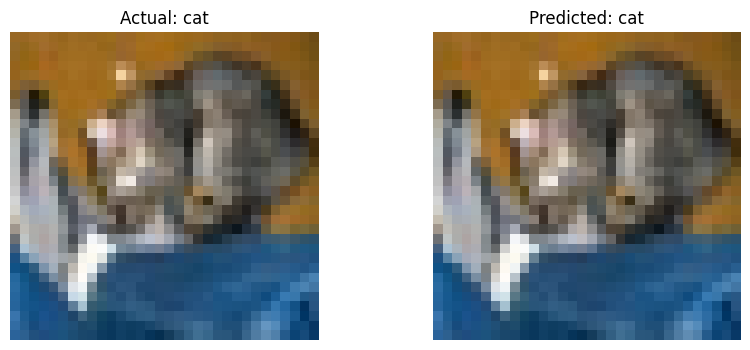

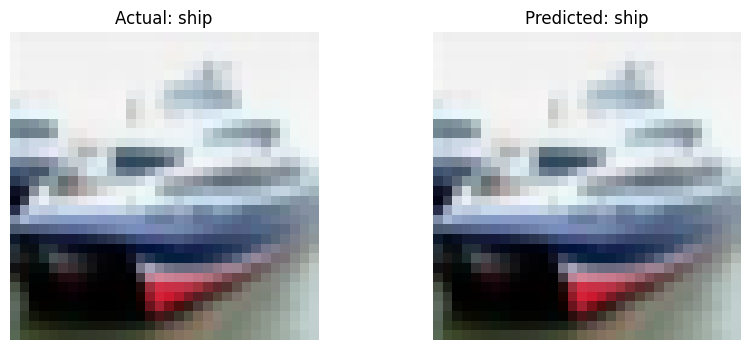

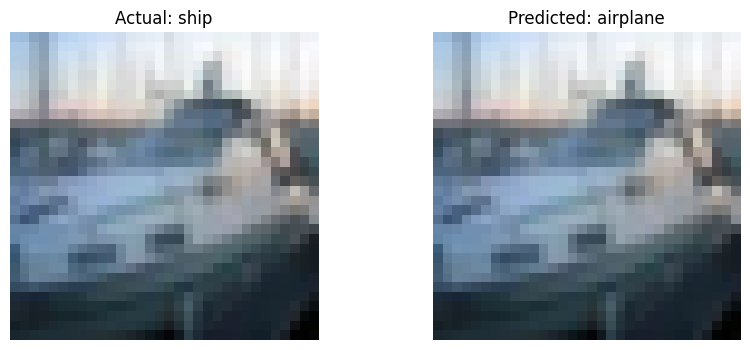

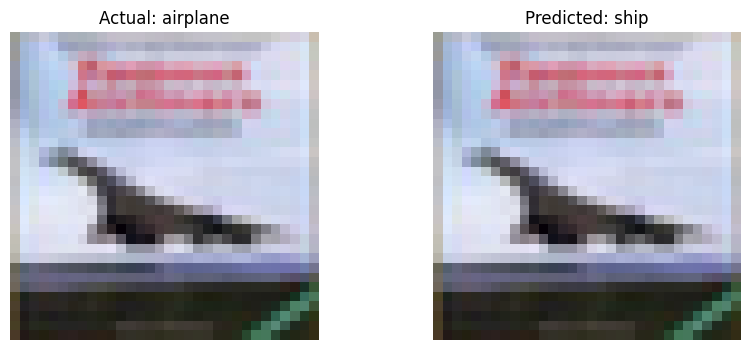

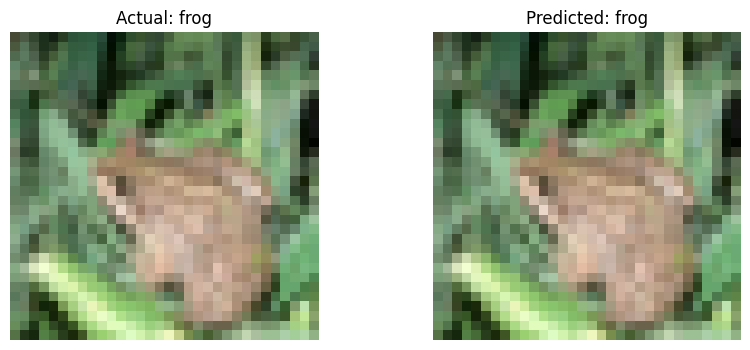

In [37]:
def display_predictions(predictions: np.ndarray, test_images: torch.Tensor, test_labels: torch.Tensor, class_names: List[str], num_images=5) -> None:
    """
    Displays the actual and predicted labels for a subset of test images.
    """
    # Ensure tensors are on CPU
    test_images = test_images.cpu()
    test_labels = test_labels.cpu()
    
    num_images = min(num_images, len(test_images))
    for i in range(num_images):
        plt.figure(figsize=(10, 4))
        
        # Display the original image with actual label
        plt.subplot(1, 2, 1)
        plt.imshow(rescale_image(test_images[i]))
        plt.axis('off')
        plt.title(f'Actual: {class_names[test_labels[i].item()]}')
        
        # Display the original image with predicted label
        plt.subplot(1, 2, 2)
        plt.imshow(rescale_image(test_images[i]))
        plt.axis('off')
        plt.title(f'Predicted: {class_names[np.argmax(predictions[i])]}')
        
        plt.show()

# Assume predictions, test_images, test_labels, and class_names are already defined

# Call the function
display_predictions(predictions, test_images, test_labels, class_names)

## Generative Adversarial Network (GAN)

This section demonstrates how to create, compile, train, and generate images using a Generative Adversarial Network (GAN). GANs consist of two neural networks, a generator and a discriminator, that compete against each other to produce realistic images.

### Steps:
1. **Create the generator and discriminator models.**
2. **Compile the models with appropriate optimizers and loss functions.**
3. **Train the GAN on a dataset of images obtained from the European Space Agency**
4. **Generate and display new images using the trained generator.**

# Applications of GANs in Satellite Imagery Processing

GANs (Generative Adversarial Networks) can significantly enhance the processing and analysis of satellite imagery in various ways:

1. **Super-resolution**
   - Enhance the resolution of low-quality satellite images
   - Useful for working with older or lower-resolution satellite data

2. **Image-to-image translation**
   - Transform images between different domains (e.g., daytime to nighttime)
   - Convert between different spectral bands

3. **Cloud removal**
   - Remove cloud cover from images to reveal ground features

4. **Data augmentation**
   - Generate synthetic satellite imagery to expand training datasets

5. **Change detection**
   - Compare GAN-generated "expected" images with actual imagery to detect changes

6. **Filling in missing data**
   - Reconstruct missing or corrupted parts of satellite images

7. **Multi-temporal analysis**
   - Generate time series of satellite imagery for studying changes over time

8. **Domain adaptation**
   - Adapt imagery from one geographic region to match characteristics of another

9. **Sensor fusion**
   - Combine data from multiple satellite sensors into composite images

10. **Anomaly detection**
    - Identify unusual features or patterns in satellite imagery

These applications can improve the quality and usability of satellite data, enabling more accurate analysis in fields such as:

- Environmental monitoring
- Urban planning
- Agriculture
- Disaster response

The specific application of GANs in your project would depend on your particular challenges and goals. For instance:

- Use super-resolution for low-quality imagery
- Apply cloud removal if cloud cover is a significant issue
- Implement change

In [ ]:
import requests
from tqdm import tqdm
import os
import zipfile
from PIL import Image
import io
import random
from torchvision.utils import save_image

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

In this setup, we're not generating anomalous images. Instead, we're using the existing EuroSAT dataset to create a dataset suitable for anomaly detection. Here's how it works:

1. We define certain classes as "normal" (e.g., 'Forest', 'AnnualCrop').
2. All other classes in the dataset are considered potential "anomalies".
3. We create a dataset that consists mostly of "normal" images, with a small percentage of "anomalous" images mixed in.

This approach is based on the idea that in a real-world anomaly detection scenario, you typically have mostly normal data with occasional anomalies.

Here's a breakdown of what the code is doing:

1. It downloads all images from the EuroSAT dataset.
2. It separates the images into two categories:
   - Normal: Images from the classes specified in `normal_classes`
   - Anomaly: Images from all other classes
3. It keeps all the "normal" images.
4. It randomly selects a subset of the "anomaly" images to match the specified `anomaly_ratio`.
5. It combines these normal and anomaly images to create the final dataset.

The resulting dataset can be used to train and evaluate anomaly detection models, including GANs. Here's how you might use it with a GAN:

1. Train the GAN only on the normal images (label 0).
2. Use the trained GAN to detect anomalies:
   - The GAN should be able to reconstruct normal images well.
   - It should struggle to reconstruct anomalous images (which it wasn't trained on).
   - This difference in reconstruction quality can be used to detect anomalies.

We're not generating new anomalous images. Instead, we're using real images from different classes as stand-ins for anomalies. This approach allows us to create a controlled dataset for developing and testing anomaly detection methods.

In [ ]:
class EuroSATAnomalyDataset(Dataset):
    def __init__(self, image_size=64, normal_classes=None, anomaly_ratio=0.1):
        self.image_size = image_size
        self.classes = ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 
                        'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']
        self.normal_classes = normal_classes if normal_classes else ['Forest']
        self.anomaly_ratio = anomaly_ratio
        self.transform = transforms.Compose([
            transforms.Resize((image_size, image_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
        ])
        self.data = self.download_and_extract_dataset()

    def download_and_extract_dataset(self):
        url = "http://madm.dfki.de/files/sentinel/EuroSAT.zip"
        print("Downloading EuroSAT dataset...")
        response = requests.get(url, stream=True)
        total_size = int(response.headers.get('content-length', 0))

        normal_data = []
        anomaly_data = []

        for file in tqdm(zf.namelist()):
            if file.endswith('.jpg'):
                image_data = zf.read(file)
                image = Image.open(io.BytesIO(image_data))
                class_name = file.split('/')[1]
                label = self.classes.index(class_name)
                
                if class_name in self.normal_classes:
                    normal_data.append((image, 0))  # 0 for normal
                else:
                    anomaly_data.append((image, 1))  # 1 for anomaly

        # Balance the dataset
        num_normal = len(normal_data)
        num_anomaly = int(num_normal * self.anomaly_ratio)
        anomaly_data = random.sample(anomaly_data, num_anomaly)

        data = normal_data + anomaly_data
        random.shuffle(data)

        print("Dataset preparation complete!")
        return data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image, label = self.data[idx]
        image = self.transform(image)
        return image, label



In [ ]:
def load_eurosat_anomaly_dataset(batch_size=32, image_size=64, normal_classes=None, anomaly_ratio=0.1, num_workers=4):
    dataset = EuroSATAnomalyDataset(image_size, normal_classes, anomaly_ratio)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    return dataloader, dataset

# Usage
batch_size = 32
image_size = 64
normal_classes = ['Forest', 'AnnualCrop']  # You can specify multiple "normal" classes
anomaly_ratio = 0.1  # 10% of the dataset will be anomalies

dataloader, dataset = load_eurosat_anomaly_dataset(batch_size, image_size, normal_classes, anomaly_ratio)

# Print some information about the dataset
print(f"Dataset size: {len(dataset)}")
print(f"Normal classes: {dataset.normal_classes}")
print(f"Anomaly ratio: {dataset.anomaly_ratio}")

# Check the balance of normal and anomaly samples
normal_count = sum(1 for _, label in dataset if label == 0)
anomaly_count = sum(1 for _, label in dataset if label == 1)
print(f"Normal samples: {normal_count}")
print(f"Anomaly samples: {anomaly_count}")

In [ ]:
class Generator(nn.Module):
    """
    Generator model for a Generative Adversarial Network (GAN).

    This Generator takes a random noise vector of size 100 and transforms it 
    into a 28x28 grayscale image. The architecture consists of several fully 
    connected layers with increasing sizes, followed by batch normalization 
    and LeakyReLU activation. The final layer uses a Tanh activation to produce 
    pixel values in the range [-1, 1].

    The network structure is as follows:
    1. Input: 100-dimensional noise vector
    2. Hidden layer: 256 neurons with BatchNorm and LeakyReLU
    3. Hidden layer: 512 neurons with BatchNorm and LeakyReLU
    4. Hidden layer: 1024 neurons with BatchNorm and LeakyReLU
    5. Output layer: 784 neurons (28*28*1) with Tanh activation

    The output is then reshaped into a 28x28x1 image.

    Attributes:
        model (nn.Sequential): The sequential container of layers.

    Methods:
        forward(x): Defines the computation performed at every call.
    """

    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2),
            
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2),
            
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            
            nn.Linear(1024, 28 * 28 * 1),
            nn.Tanh(),
        )

    def forward(self, x):
        """
        Forward pass of the generator.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, 100)

        Returns:
            torch.Tensor: Generated images of shape (batch_size, 1, 28, 28)
        """
        img = self.model(x)
        img = img.view(-1, 1, 28, 28)
        return img



In [ ]:
def build_generator() -> nn.Module:
    """
    Builds and returns an instance of the Generator model.

    Returns:
        nn.Module: An instance of the Generator model.
    """
    return Generator.to(device)

In [ ]:
class Discriminator(nn.Module):
    """
    Discriminator model for a Generative Adversarial Network (GAN).

    This Discriminator takes a 28x28 grayscale image and classifies it as real 
    or fake. The architecture consists of several fully connected layers with 
    decreasing sizes, using LeakyReLU activations. The final layer uses a 
    Sigmoid activation to produce a probability output.

    The network structure is as follows:
    1. Input: 28x28x1 image (flattened to 784-dimensional vector)
    2. Hidden layer: 512 neurons with LeakyReLU
    3. Hidden layer: 256 neurons with LeakyReLU
    4. Output layer: 1 neuron with Sigmoid activation

    Attributes:
        model (nn.Sequential): The sequential container of layers.

    Methods:
        forward(x): Defines the computation performed at every call.
    """

    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28 * 28 * 1, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        """
        Forward pass of the discriminator.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, 1, 28, 28)

        Returns:
            torch.Tensor: Probability of input being real, shape (batch_size, 1)
        """
        return self.model(x)



In [ ]:
def build_discriminator() -> nn.Module:
    """
    Builds and returns an instance of the Discriminator model.

    Returns:
        nn.Module: An instance of the Discriminator model.
    """
    return Discriminator.to(device)

In [ ]:
class DiscriminatorTrainer:
    def __init__(self, generator, discriminator, config):
        self.generator = generator
        self.discriminator = discriminator
        self.config = config
        
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        # Move models to the appropriate device
        self.generator.to(self.device)
        self.discriminator.to(self.device)
        
        self.criterion = nn.BCELoss()
        self.optimizer_G = optim.Adam(self.generator.parameters(), 
                                      lr=config['lr'], 
                                      betas=(config['beta1'], config['beta2']))
        self.optimizer_D = optim.Adam(self.discriminator.parameters(), 
                                      lr=config['lr'], 
                                      betas=(config['beta1'], config['beta2']))

    def train_step(self, real_images):
        batch_size = real_images.size(0)
        real_images = real_images.to(self.device)

        # Train Discriminator
        self.optimizer_D.zero_grad()
        
        # Real images
        real_labels = torch.ones(batch_size, 1).to(self.device)
        output = self.discriminator(real_images)
        d_loss_real = self.criterion(output, real_labels)
        
        # Fake images
        z = torch.randn(batch_size, self.config['latent_dim'], 1, 1).to(self.device)
        fake_images = self.generator(z)
        fake_labels = torch.zeros(batch_size, 1).to(self.device)
        output = self.discriminator(fake_images.detach())
        d_loss_fake = self.criterion(output, fake_labels)
        
        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        self.optimizer_D.step()

        # Train Generator
        self.optimizer_G.zero_grad()
        output = self.discriminator(fake_images)
        g_loss = self.criterion(output, real_labels)
        g_loss.backward()
        self.optimizer_G.step()

        return d_loss.item(), g_loss.item()

    def train(self, dataloader):
        for epoch in range(self.config['num_epochs']):
            for i, (real_images, labels) in enumerate(dataloader):
                # Only use normal images (label 0)
                real_images = real_images[labels == 0]
                if real_images.size(0) == 0:
                    continue  # Skip this batch if it contains no normal images

                d_loss, g_loss = self.train_step(real_images)

                # Print progress
                if i % self.config['print_every'] == 0:
                    print(f"[Epoch {epoch}/{self.config['num_epochs']}] [Batch {i}/{len(dataloader)}] "
                          f"[D loss: {d_loss:.4f}] [G loss: {g_loss:.4f}]")

            # Save generated images
            if (epoch + 1) % self.config['save_interval'] == 0:
                self.save_images(epoch)

        print("Training finished!")
        self.save_models()

    def save_images(self, epoch):
        with torch.no_grad():
            fake = self.generator(torch.randn(64, self.config['latent_dim'], 1, 1, device=self.device))
            save_image(fake.detach(), f"fake_images_epoch_{epoch+1}.png", normalize=True)

    def save_models(self):
        torch.save(self.generator.state_dict(), "generator.pth")
        torch.save(self.discriminator.state_dict(), "discriminator.pth")

    def detect_anomalies(self, images, threshold):
        self.generator.eval()
        self.discriminator.eval()
        with torch.no_grad():
            z = torch.randn(images.size(0), self.config['latent_dim'], 1, 1).to(self.device)
            reconstructed = self.generator(z)
            reconstruction_error = torch.mean((images - reconstructed) ** 2, dim=(1, 2, 3))
            anomaly_scores = reconstruction_error
            return anomaly_scores > threshold


In [ ]:
# Usage
config = {
    'latent_dim': 100,
    'lr': 0.0002,
    'beta1': 0.5,
    'beta2': 0.999,
    'num_epochs': 100,
    'batch_size': 64,
    'image_size': 64,
    'print_every': 100,
    'save_interval': 10
}
trainer = DiscriminatorTrainer(discriminator)